# Dynamic Time Warping for Sequence-to-Sequence Matching

String and Sequence Matching problems refer to problems in which the sequences to be compared can be of different length.   Aligning them is an intrinsic ingredient of the solution.
The matching measure or distance is an accumulation of so called local distances that can be computed on the elements of the sequences.

The well known **Levenshtein** algorithm is commonly used when the sequence elements are atoms drawn from a final alphabet, such as the letter of the alphabet in string comparison.

When the sequences are made up of real numbers or vectors and the sequence is time based, we tend to refer to **Dynamic Time Warping** as in speech applications.

These two algorithms are intrinsically the same and may generally speaking be referred to as implementations of the **Dynamic Programming Principle**.   Obviously the local distance measure is different when operating on atoms or continuous vectors.   Also the transition constraints may be application dependent.

In this tutorial we use **DTW** as a generic name; also because we use the *pyspch.dtw* module for the computations.
______   



DTW finds a sequence distance between two sequences data 
$$ 
X_{i=1:N} \text{  and  } Y_{j=1:M}  
$$

The **sequence distance** is the minimum of the cummulative distances amongst all possible alignment paths
$$
(X_{i(s)},Y_{j(s)} ) \text{  for } s=1 ... L 
$$

whereas the cummulative distance along a given path is defined as:   
$$
\sum_s  D_l\left(X_{i(s)}, Y_{j(s)}\right) + D_t\left(\it{trans}\right) 
$$   
with:  $ trans = \left( i(s)-i(s-1),  j(s)-j(s-1) \right) $

+ with $D_l(X,Y)$ denoting a *local distance measure* that measures distance between 2 feature vectors
+ with $D_t(..)$ denoting a *transition cost* depending on the transition that was taken
+ boundary constraints:
    + if you need $\{X\}$ to be a match for $\{Y\}$ then the alignment should start in the origin $(1,1)$ and end in $(N,M)$
    + if you want to find the best possible subsequence match of $\{X\}$ in $\{Y\}$, then any starting point (1,j_1) and any endig point (N,j_L) is acceptable  
+ certain transition constraints are generic:
    +  $i$ and $j$ need to *progress* in time, i.e. $i(s+1) >= i(s)$
    + the diagonal transition (+1,+1) is natural and by default included in the list of allowed transitions
+ certain transition constraints are specific to the applied transition model:
    + In a Levenshtein model for string matching
        * DIAGONAL: (+1,+1), INSERTION: (+1,0), DELETION: (0,+1)
        * For INSERTION and DELETION only a fixed transition cost is added
        * For DIAGONAL transitions the local distance cost is added 
    + In (vanilla) DTW 
        * the basic transitions are: (+1,+1), (+1,0), (0,+1)
        * a local distance metric is defined, allowing to built the local distance matrix $D_l\left(X_i, Y_j\right)$
        * either no transition costs are taken into account, or a transition penalty is added to the non diagonal transitions
     + In Symmetric Itakura
         * the possible transitions are: (+1,+1), (+2,+1), (+1,+2)
         * a local distance matrix is built as above
         * the long moves may be seen as double transitions, therefore the local distances 'along the way' should be accumulated; alternatively a multiplicative cost (eg. 2) can be implemented
         
The two DTW models described above, can be visualized as here:
[dtw_constraints](../figures/dtw_constraints.png)


In [1]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## Example 1:  1D feature vectors
- first define two some sequences   
    The feature vectors are scalars (1D vectors) 
- run a standard DTW algorithm on it and print a trellis
- 3 examples are given with slight differences in local distance metric and transition constraints
    + ex1a: Euclidean distance and standard DTW (Levenshtein) warping constraints
    + ex1b: Magnitude distance and standard DTW (Levenshtein) warping constraints
    + ex1c: Euclidean distance and Itakura constraints allowing for local 1x2 or 2x1 speed differences
    

In [194]:
# Example 1a.
#################
x1d = np.array([.05, -.1, 0.77, .335, .95, 1.75])
y1d = np.array([0.,1.,2.])
dtw_args = {'trans':'DTW','p':2}
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':5,'ftr_scale':.15,'fmt':"{:.2f}",'text_size':"medium"}

In [224]:
# Example 1b.
#################
x1d = np.array([0, 5, 8, 5,4])
y1d = np.array([1, 5, 7, 8, 7, 2])
#def absdist(x,y):
#    ld_func = 
dtw_args = {'trans':'DTW','p':1}
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':5,'ftr_scale':.15,'fmt':"{:.0f}",'text_size':"medium",'fontweight':'bold'}

In [245]:
# Example 1c.
#################
#x1d = np.array([1, 2, 3, 4, 5, 4, 3, 1, 4, 6, 5, 4, 3, 2, 1])
#y1d = np.array([1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 1, 2.5, 5,5, 3., 1,])
x1d = np.array([1,3,5,7,9,6,3,1,7,10,8,6,4,2])
y1d = np.array([1.2, 2.9, 4.6, 6.8, 8.5, 8, 6, 4, 2, 1.1, 1.3,1 ,4, 9,4,1])
#trans = {'dx':[-1,-1,0,-2,-1], 'dy':[-1,0,-1,-1,-2], 'a':[0,15,15,2,2,],'m':[1.0,5.0,5.0,2,2] }             
dtw_args = {'trans':'ITA','p':2,'CLIP':True}
plt_args = {'xy_annot':False,'ftr_annot':False,'ftr_lines':True,'fig_width':5,'ftr_scale':.075,'fmt':"{:.1f}",'text_size':"xx-small",
            'xy_args':{'cmap':'rainbow','alpha':.6}}


DTW distance: 15.650 


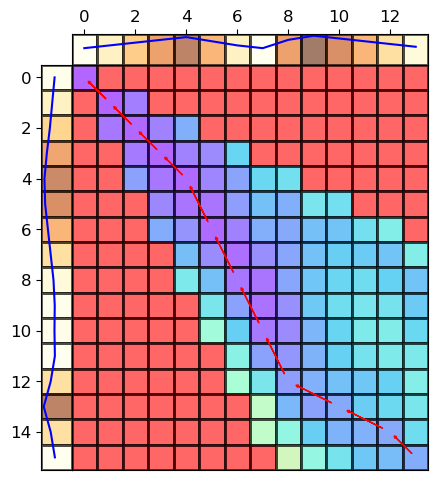

In [246]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,**dtw_args,result='details')
print("DTW distance: %.3f " % dist)
dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)

## Steps in the DTW algorithm
1. Local Distance Computation
Compute for each pair (x_i, y_j) a distance.  This feature by feature distance, organized in a matrix is called the "local distance matrix"
2. Trellis Computation
In a trellis we compute accumulated distances.  Each cell contains a sum of local distances , starting up to the current cell.
Thus cell (Nx,Ny) contains the full sequence distance.   
Obviously the computation of cummulative distance this is subject to the allowed transitions.  
To maintain the memory of how we moved from one cell to another
we add backpointers in each cell
3. Backtracking
In order to find the alignment between the two sequences. We follow backpointers from the end back to the start

### Trellis Representation
The trellis is a matrix arrangement in which each cell (i,j) says something about the relationship between x\[i\] and y\[j\] or up to that moment in time for both sequences.   
We tend to add extra space in the plot for the feature vectors, typically clearly visable by the different colormaps.

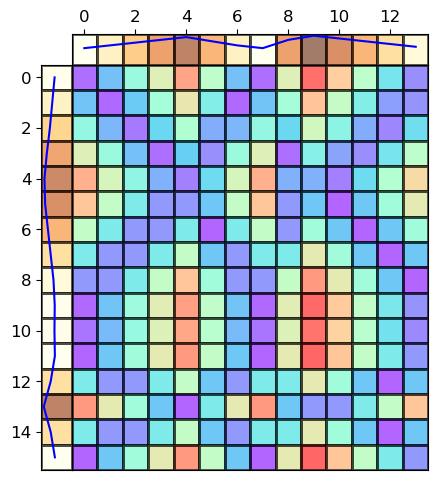

In [247]:
#STEP1: Compute the local distance matrix
fig1 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=ld_matrix,**plt_args)
fig1

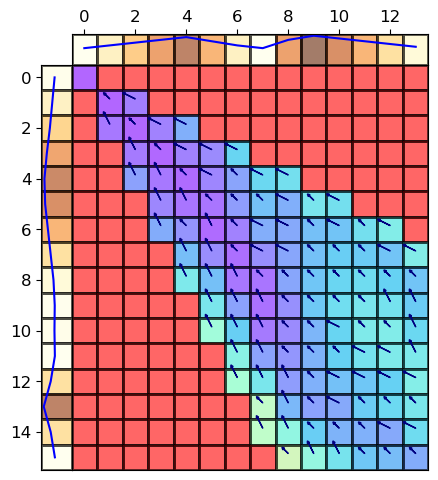

In [248]:
# STEP2: Compute the Cummulative Distance Matrix and add backpointers
fig2 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,bptrs=bptrs,**plt_args)
fig2

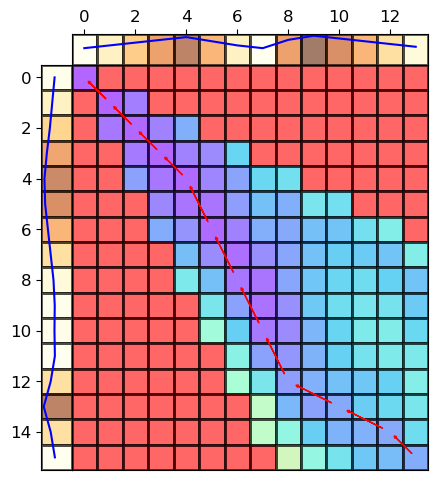

In [249]:
# STEP 3: Follow the backpointers in reverse order from end to beginning to find the optimal alignment
#xy_annot=True,ftr_annot=True,fig_width=4,fmt="{:.3f}",text_size="x-small"

fig3 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig3)

In [250]:
# save the figures
fig1.savefig("ex_ldmat")
fig2.savefig("ex_backptrs")
fig3.savefig("ex_backtrace")


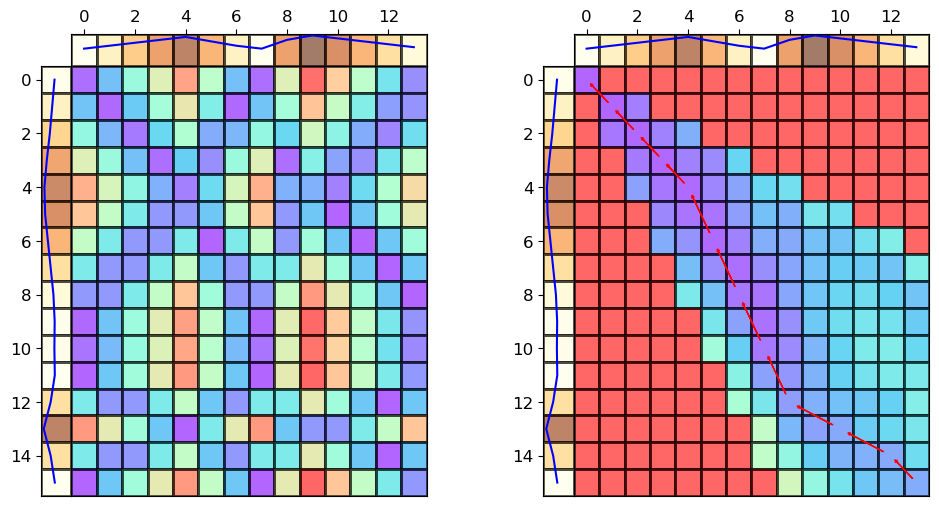

In [251]:
# we can also plot 2 side by side
fig = dtw.plot_trellis2(x1d,y1d,ld_matrix,cd_matrix,trace=trace,figsize=(10,6),**plt_args)
display(fig)

In [200]:
# compute "warped" versions of x,y on the basis of an alignment
# note: a warping obtained on 1 set of features can be applied to another set 
# given that the feature sequences are equally long for both processing types
x_wp,y_wp = dtw.warp(x1d,y1d,trace)
pd.DataFrame((x_wp,y_wp))

,0,1,2,3,4,5
0,0.05,-0.1,0.77,0.335,0.95,1.75
1,0.00,0.0,1.00,1.000,1.00,2.00


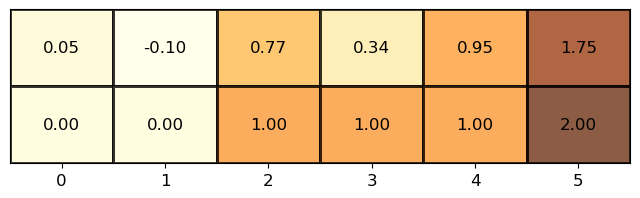

In [204]:
f,ax=plt.subplots(figsize=(8,2))
ax.set_yticks([])
ax.invert_yaxis()
dtw.text_heatmap(np.array([x_wp,y_wp]),ax=ax,annot=True,edgecolor='k',cmap='YlOrBr',alpha=.75)

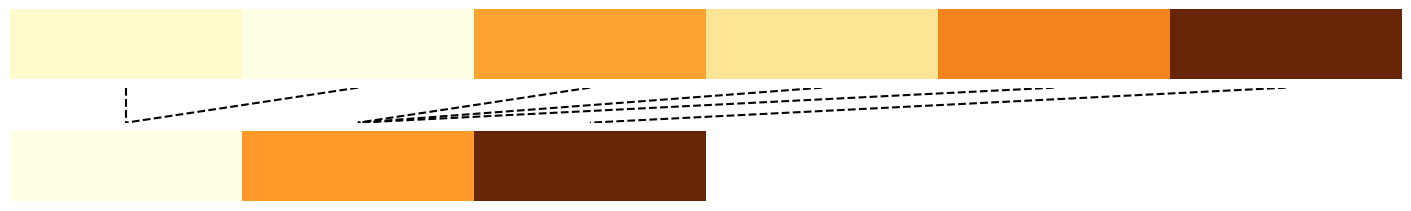

In [205]:
dtw.plot_align(x1d,y1d,trace,figsize=(14,2))

Text(0.5, 1.0, 'Y-warped')

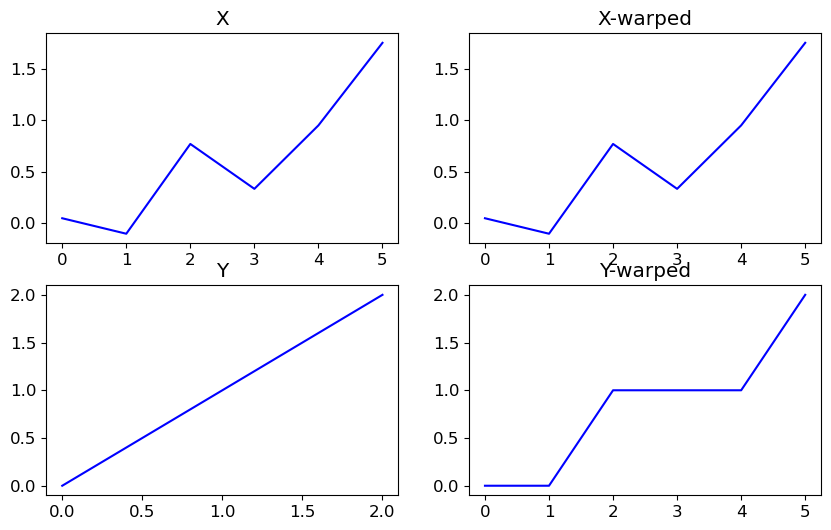

In [202]:
fig,ax = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(x1d)
ax[0,0].set_title("X")
ax[1,0].plot(y1d)
ax[1,0].set_title("Y")
ax[0,1].plot(x_wp)
ax[0,1].set_title("X-warped")
ax[1,1].plot(y_wp)
ax[1,1].set_title("Y-warped")
#for axx in ax:
#    axx.spines.top.set(visible=False)
#    axx.spines.right.set(visible=False)

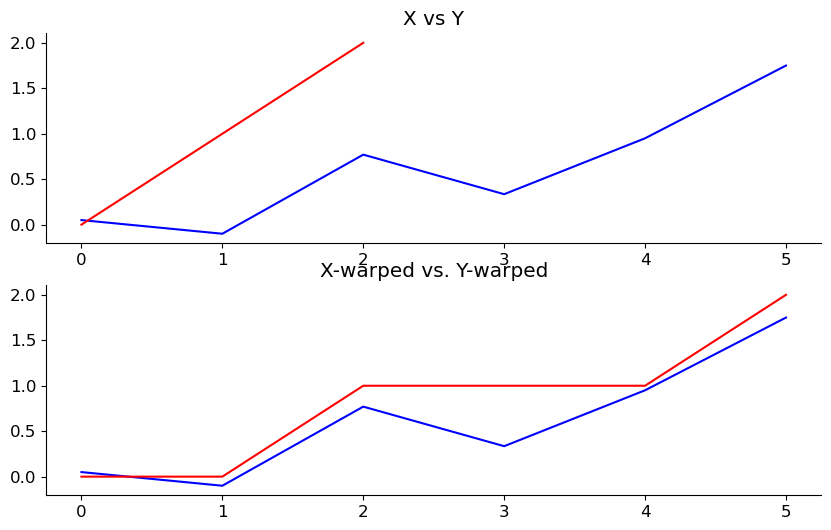

In [203]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
ax[0].plot(x1d)
ax[0].set_title("X vs Y")
ax[0].plot(y1d,color='r')
#ax[1,0].set_title("Y")
ax[1].plot(x_wp)
ax[1].set_title("X-warped vs. Y-warped")
ax[1].plot(y_wp,color='r')
#ax[1,1].set_title("Y-warped")
for axx in ax:
    axx.spines.top.set(visible=False)
    axx.spines.right.set(visible=False)

In [82]:
def plot_align_1d(x,y,trace,*,figsize=(10,4),down_sample=1):
    ''' 
    plots alignment of 1D feature data
    '''
    row_heights = [1.,.25,1.]
    ax_x = 0
    ax_tr = 1
    ax_y = 2
    max_len = max(len(x),len(y))
    plt_range = [-.5,max_len+.5]
    
    fig = Spd.SpchFig(row_heights=row_heights, figsize=figsize )
    
    fig.add_line_plot(x,iax=ax_x,xrange=plt_range)
    fig.add_line_plot(y,iax=ax_y,xrange=plt_range)

    if(trace is not None):
        fig.axes[ax_tr].set_ylim([-1.,1.])
        fig.axes[ax_tr].set_xlim([plt_range[0],plt_range[1]])
        ax = fig.axes[ax_tr]
        for i in range(0,len(trace),down_sample) :
            ax.plot(trace[i],[1,-1],linestyle='dashed',color='k')        
    for ax in fig.axes:
        ax.axis('off')

    return(fig)

def plot_align_1dwp(x,y,trace,*,figsize=(10,4),down_sample=1):
    ''' 
    plots alignment of 1D feature data
    '''
    fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True, sharey=True)
    #ax[0,0].set_axis_off()
            
    max_len = max(len(x),len(y))
    plt_range = [-.5,max_len+.5]

    ax[0,0].plot(x)
    ax[1,0].plot(y,'r')
    ax[0,0].set_title("X vs. Y")

    x_wp,y_wp = dtw.warp(x,y,trace)
    ax[0,1].plot(x_wp)
    ax[1,1].plot(y_wp,'r')
    ax[0,1].set_title("X-warped vs. Y-warped")
    ax[1,0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    for i in (0,1):
        for j in (0,1):
            ax[i,j].spines.top.set(visible=False)
            ax[i,j].spines.right.set(visible=False)
    return(fig)

def plot_align_1dwp_x(x,y,trace,*,figsize=(10,4),down_sample=1):
    ''' 
    plots alignment of 1D feature data
    '''
    row_heights = [1.,1.,1.,1.,1.]
    fig = Spd.SpchFig(row_heights=row_heights, figsize=figsize )
    for ax in fig.axes:    ax.set_axis_off()
            
    max_len = max(len(x),len(y))
    plt_range = [-.5,max_len+.5]
    
    fig.add_line_plot(x,iax=0,xrange=plt_range,title='X vs Y')
    fig.add_line_plot(y,iax=1,xrange=plt_range)

    xwp,ywp = dtw.warp(x,y,trace)
    fig.add_line_plot(xwp,iax=3,xrange=plt_range,color='r',title="WARPED X vs. Y")
    fig.add_line_plot(ywp,iax=4,xrange=plt_range,color='r')

    return(fig)

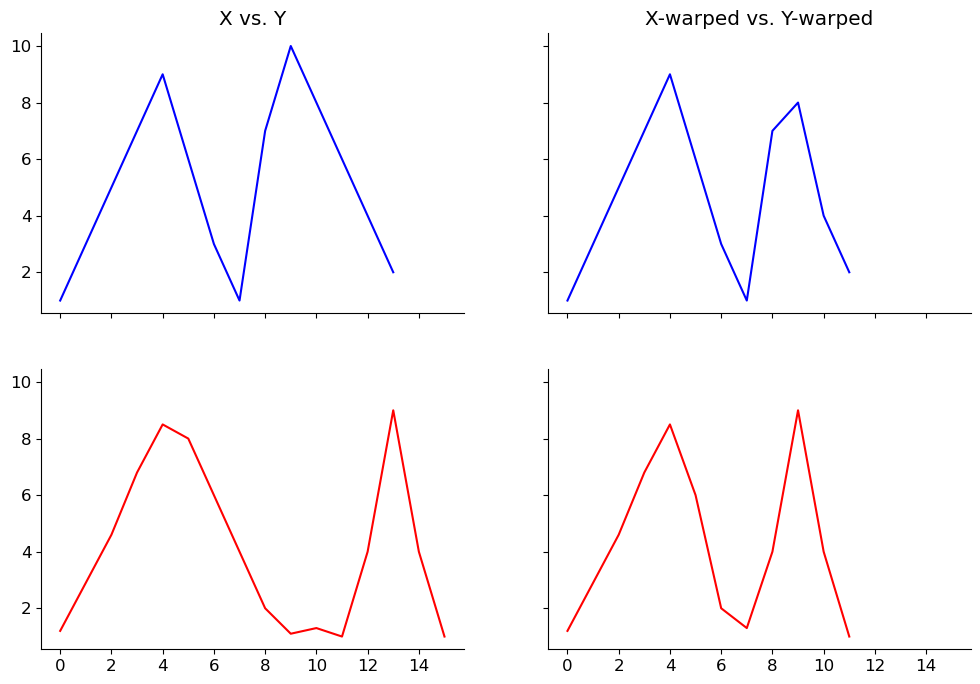

In [83]:
plot_align_1dwp(x1d,y1d,trace);

In [120]:
def plot_xy(x,y,figsize=(12,3),xlim=None,labels=["x","Y"],title=""):
    fig,ax = plt.subplots(2,1,figsize=figsize,sharex=True, sharey=True)

    max_len = max(len(x),len(y))
    plt_range = [-.5,max_len+.5]

    lx, = ax[0].plot(x)
    ly, = ax[1].plot(y,'r')
    if xlim is not None: ax[0].set_xlim(xlim)
    for i in (0,1):
        ax[i].spines.top.set(visible=False)
        ax[i].spines.right.set(visible=False)
    fig.suptitle(title)
    ax[0].legend([lx],[labels[0]],loc='upper right')
    ax[1].legend([ly],[labels[1]],loc='upper right')
    return(fig)

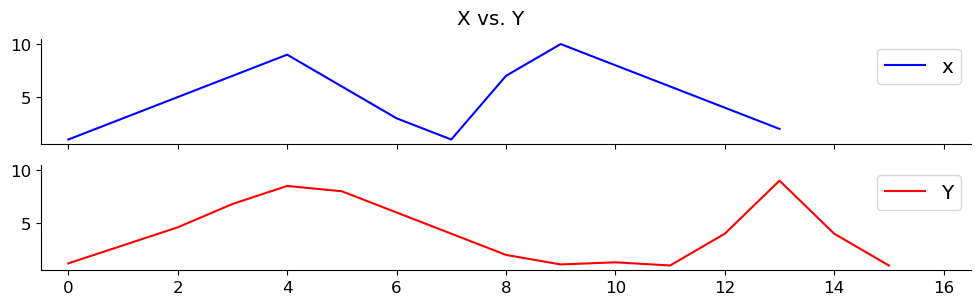

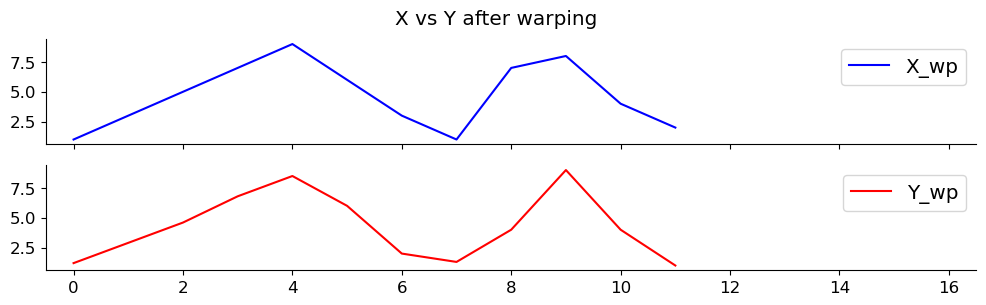

In [131]:
n = max(len(x1d),len(y1d),len(x_wp),len(y_wp))
xlim=[-.5,n+.5]
fig1 = plot_xy(x1d,y1d,xlim=xlim,title="X vs. Y");
fig2 = plot_xy(x_wp,y_wp,xlim=xlim,title="X vs Y after warping",labels=['X_wp','Y_wp']);
fig1, fig2;

In [ ]:
x1d = np.array([.05, 1.3, 1.7, 0.77, -1.,0.,-0.5, .95, 1.75,2.7,.3])
y1d = np.array([0.,1.,2.,0.,.5,2,1.,0.])
# we also define some plotting arguments for this example
plt_args = {'xy_annot':True,'ftr_annot':False,'fig_width':10,'ftr_scale':.05,'fmt':"{:.2f}",'text_size':"xx-small"}
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,trans='DTW',result='details')
print("DTW distance: %.3f " % dist)

dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,bptrs=bptrs,trace=trace,**plt_args)
dtw.plot_trellis2(x1d,y1d,ld_matrix,cd_matrix,bptrs=bptrs,trace=trace,**plt_args)

## Multi-dimensional Features
In this exampe we pass 2D feature vectors

In [252]:
#x2d = np.array([[0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],[0.3,1.3,1.5,1.5,1.,0.3,-0.24,0.3,.05]]).T
x2d = np.array([[0.,1.,2.,1.,0.,0.1,.05],[0.3,1.3,1.5,1.5,1.,0.3,.05]]).T
y2d = np.array([[0.,0.,0.,1.,2],[1.,1.,1.,1.,-1]]).T + .1*np.random.rand(5,2)
plt_args = {'fig_width':8,'xy_annot':True,'ftr_annot':True,            
            'xy_args':{'alpha':.2,'edgecolor':'k'}, 
            'bptr_args':{'color':'orange','linewidth':3},
            'ftr_args':{'cmap':'YlOrBr','edgecolor':'g','alpha':.3},
            }



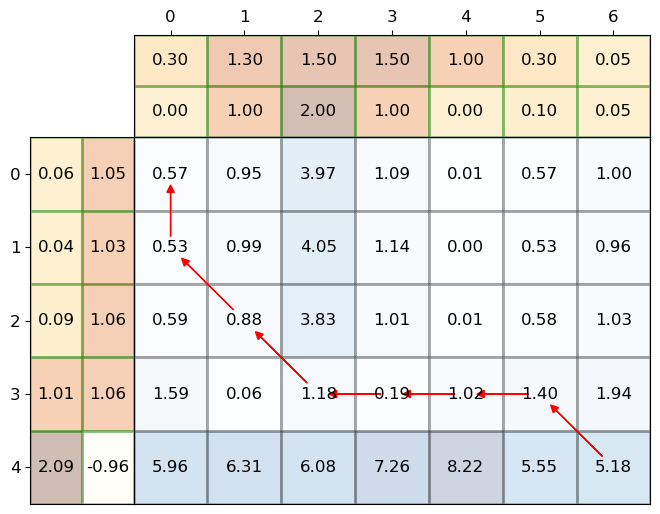

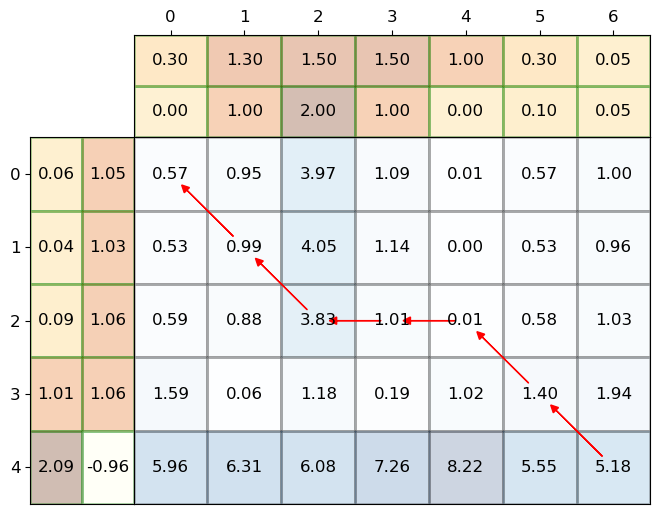

In [253]:
# By increasing the costs for off-diagonal transition, you force the alignment to become maximally diagonal
x_ftrs=x2d
y_ftrs=y2d
# case 1: small off-diagonal costs
trans = {'dx':[-1,-1,0], 'dy':[-1,0,-1], 'm':[1.0,1.2,1.2] }
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans=trans,result='details')
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
# case 2: large off-diagonal costs
trans = {'dx':[-1,-1,0], 'dy':[-1,0,-1], 'm':[1.0,2.,2.] }
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans=trans,result='details')
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)

## ITAKURA constraints
In sequence matching one may generally expect that the alignment path will follow the main diagonal closely. 
Long verticle or horizontal segments in the alignment are indications of a bad mismatch or significant insertion/deletions at those locations.

In the case of speech, things are no different as speaking rate differences tend to be limited.
Hence, popular in the speech community are the so called ITAKURA constraints in sequence matching.   
Itakura allows single jump in x or y direction while the other index just increases by 1 .  
In the dtw.dtw() implementation we penalize such jump moves by 20% vs. regular diagonal moves.   
This allows for a speedup of x2 on either axis.
At the same time it implies that certain cells in the trellis can never be reached.  
One of the bigger problems is that it is very hard to align variable length noise segments as for these a warping >> 2 may be acceptable.

In the dtw() module a few alternatives are available, that may be selected depending on the application:

- ITA: baseline symmetric DP with single jump allowed in x or y
- ITX: Itakura like DP, time synchronous with x-axis
- ITY: Itakura like DP, time synchronous with y-axis
- ITX3: x-time synchronous DP with Delta-y up to 3
- ITY3: y-time synchronous DP with Delta-x up to 3
- ITS: symmetric DP with infinite sized warping in both x and y possible
        (combintation of 'ITA' and 'DTW').  
        
Due to the warping constraints, certain areas in the trellis are not reachable and show infinite cost.  Exception is the ITS variant in which every cell in the trellis is reachable 


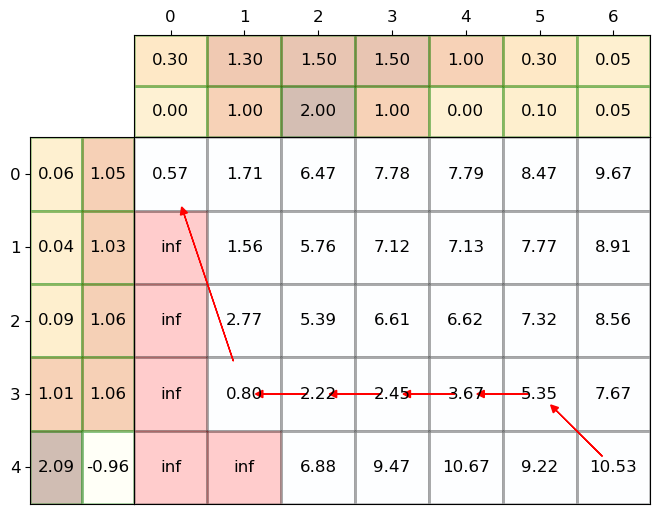

DTW distance =  10.529992535197724


In [254]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='ITX3',result='details',CLIP=False)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

## Admissible Transitions and acceptable speedups
The ITAKURA constraints allow for a maximum x2 speedup in either direction.  
This makes sense during speech, but in silence periods much more may be required.  
Therefore it is advised to combine endpointing with the ITAKURA DTW implementation. 
If Nx > 2 times Ny, then the final cell in the trellis will not be reached.
The **IT2** constraints are a mix of ITAKURA and LEVENSHTEIN but with high costs on the horizontal / vertical moves.
It will resut in an alignment for ANY lengths Nx,Ny and in matching segments the ITAKURA constraints will dominate.

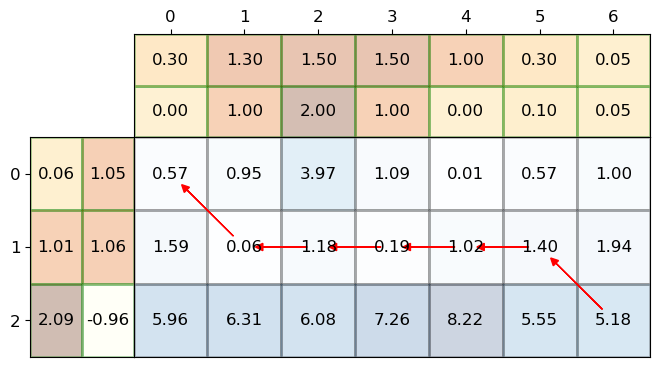

DTW distance =  9.59906907066208


In [255]:
x_ftrs=x2d
y_ftrs=y2d[(0,3,4),:]
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='DTW',result='details',CLIP=False)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)